In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 设置绘图风格
sns.set_style('whitegrid')
sns.set_palette('husl')

print("✅ 库导入成功")

✅ 库导入成功


## 1. 数据加载

In [2]:
# 定义文件路径
results_dir = Path('../results')

# 加载所有文件
files = {
    'Ambiance_BERT': 'Ambiance_sentiment_bert_base_cased.csv',
    'Ambiance_TinyRoBERTa': 'Ambiance_sentiment_tinyroberta_squad2.csv',
    'Food_BERT': 'Food_sentiment_bert_base_cased.csv',
    'Food_TinyRoBERTa': 'Food_sentiment_tinyroberta_squad2.csv',
    'Service_BERT': 'Service_sentiment_bert_base_cased.csv',
    'Service_TinyRoBERTa': 'Service_sentiment_tinyroberta_squad2.csv'
}

data = {}
for key, filename in files.items():
    filepath = results_dir / filename
    data[key] = pd.read_csv(filepath)
    print(f"✅ {key}: {len(data[key])} 行")

print(f"\n总共加载了 {len(data)} 个数据集")

✅ Ambiance_BERT: 25004 行
✅ Ambiance_TinyRoBERTa: 21667 行
✅ Food_BERT: 25004 行
✅ Food_TinyRoBERTa: 21683 行
✅ Service_BERT: 25004 行
✅ Service_TinyRoBERTa: 21667 行

总共加载了 6 个数据集


## 2. 数据结构分析

In [3]:
# 查看BERT模型数据结构
print("=== BERT模型数据结构 ===")
print("\nFood_BERT 列名:")
print(data['Food_BERT'].columns.tolist())
print("\n前3行:")
print(data['Food_BERT'].head(3))

print("\n" + "="*60)

# 查看TinyRoBERTa模型数据结构
print("\n=== TinyRoBERTa模型数据结构 ===")
print("\nService_TinyRoBERTa 列名:")
print(data['Service_TinyRoBERTa'].columns.tolist())
print("\n前3行:")
print(data['Service_TinyRoBERTa'].head(3))

=== BERT模型数据结构 ===

Food_BERT 列名:
['review', 'restaurant_id', 'city', 'question', 'answer', 'confidence', 'cosine_sim', 'sentiment']

前3行:
                                              review    restaurant_id   city  \
0  the french fry wasn t fresh the taste profile ...  Restaurant 1544  Dhaka   
1                           taste ratings out of yep  Restaurant 3815  Dhaka   
2                        taste quality ager moto nai  Restaurant 3489  Dhaka   

       question             answer  confidence  cosine_sim  sentiment  
0  Taste_Aspect  the taste profile    0.171494    0.849548   0.436155  
1  Taste_Aspect      taste ratings    0.411582    0.830429   0.231641  
2  Taste_Aspect      taste quality    0.653633    0.830022   0.351010  


=== TinyRoBERTa模型数据结构 ===

Service_TinyRoBERTa 列名:
['text', 'name', 'city', 'Food_Aspect_Answer', 'Food_Aspect_Similarity_Score', 'Service_Aspect_Answer', 'Service_Aspect_Similarity_Score', 'Ambiance_Aspect_Answer', 'Ambiance_Aspect_Similarity_Score'

## 3. 数据预处理和统一格式

In [4]:
# 标准化数据格式
def standardize_data(df, dataset_name, model_name):
    """统一不同模型输出的数据格式"""
    df_std = pd.DataFrame()
    
    # 根据模型类型提取字段
    if 'BERT' in model_name:
        df_std['text'] = df['review'] if 'review' in df.columns else df.get('text', '')
        df_std['restaurant_id'] = df.get('restaurant_id', df.get('name', ''))
        df_std['city'] = df.get('city', '')
        df_std['sentiment'] = df.get('sentiment', 0)
        df_std['confidence'] = df.get('confidence', 0)
    else:  # TinyRoBERTa
        df_std['text'] = df.get('text', '')
        df_std['restaurant_id'] = df.get('name', df.get('restaurant_id', ''))
        df_std['city'] = df.get('city', '')
        df_std['sentiment_label'] = df.get('Sentiment_Label', '')
        df_std['confidence'] = df.get('Sentiment_Confidence', 0)
        
        # 转换星级为数值
        if 'sentiment_label' in df_std.columns:
            df_std['sentiment'] = df_std['sentiment_label'].str.extract('(\d+)').astype(float) / 5.0
    
    df_std['dataset'] = dataset_name
    df_std['model'] = model_name
    df_std['text_length'] = df_std['text'].astype(str).apply(len)
    df_std['word_count'] = df_std['text'].astype(str).apply(lambda x: len(x.split()))
    
    return df_std

# 处理所有数据集
processed_data = {}
for key, df in data.items():
    dataset_name, model_name = key.split('_', 1)
    processed_data[key] = standardize_data(df, dataset_name, model_name)
    print(f"✅ 处理完成: {key}")

# 合并所有数据
all_data = pd.concat(processed_data.values(), ignore_index=True)
print(f"\n✅ 合并完成，总计 {len(all_data)} 条记录")

✅ 处理完成: Ambiance_BERT
✅ 处理完成: Ambiance_TinyRoBERTa
✅ 处理完成: Food_BERT
✅ 处理完成: Food_TinyRoBERTa
✅ 处理完成: Service_BERT
✅ 处理完成: Service_TinyRoBERTa

✅ 合并完成，总计 140029 条记录


## 4. 数据集规模对比

=== 数据集规模对比 ===
model      BERT  TinyRoBERTa
dataset                     
Ambiance  25004        21667
Food      25004        21683
Service   25004        21667


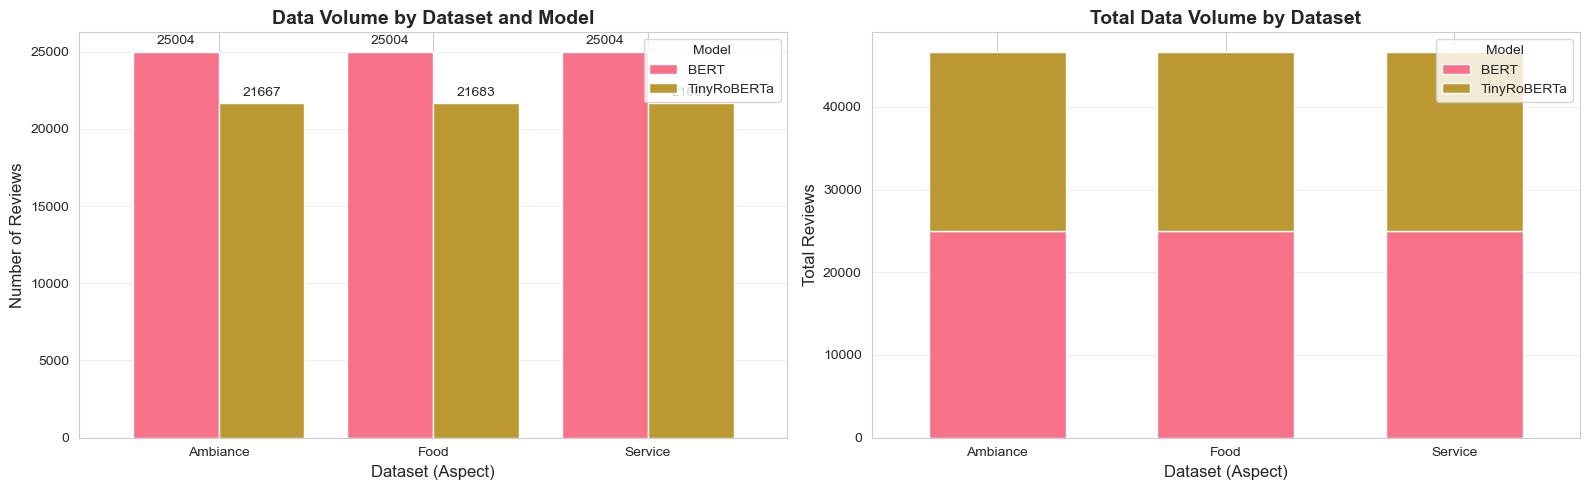


总评论数: 140,029

按数据集统计:
dataset
Food        46687
Ambiance    46671
Service     46671
Name: count, dtype: int64

按模型统计:
model
BERT           75012
TinyRoBERTa    65017
Name: count, dtype: int64


In [5]:
# 统计每个数据集的大小
dataset_sizes = all_data.groupby(['dataset', 'model']).size().reset_index(name='count')
dataset_sizes_pivot = dataset_sizes.pivot(index='dataset', columns='model', values='count')

print("=== 数据集规模对比 ===")
print(dataset_sizes_pivot)

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 子图1: 分组柱状图
dataset_sizes_pivot.plot(kind='bar', ax=axes[0], width=0.8)
axes[0].set_title('Data Volume by Dataset and Model', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dataset (Aspect)', fontsize=12)
axes[0].set_ylabel('Number of Reviews', fontsize=12)
axes[0].legend(title='Model', loc='upper right')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

# 添加数值标签
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d', padding=3)

# 子图2: 堆叠柱状图
dataset_sizes_pivot.plot(kind='bar', stacked=True, ax=axes[1], width=0.6)
axes[1].set_title('Total Data Volume by Dataset', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Dataset (Aspect)', fontsize=12)
axes[1].set_ylabel('Total Reviews', fontsize=12)
axes[1].legend(title='Model', loc='upper right')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# 总体统计
print(f"\n总评论数: {len(all_data):,}")
print(f"\n按数据集统计:")
print(all_data['dataset'].value_counts())
print(f"\n按模型统计:")
print(all_data['model'].value_counts())

## 5. 情感分布分析

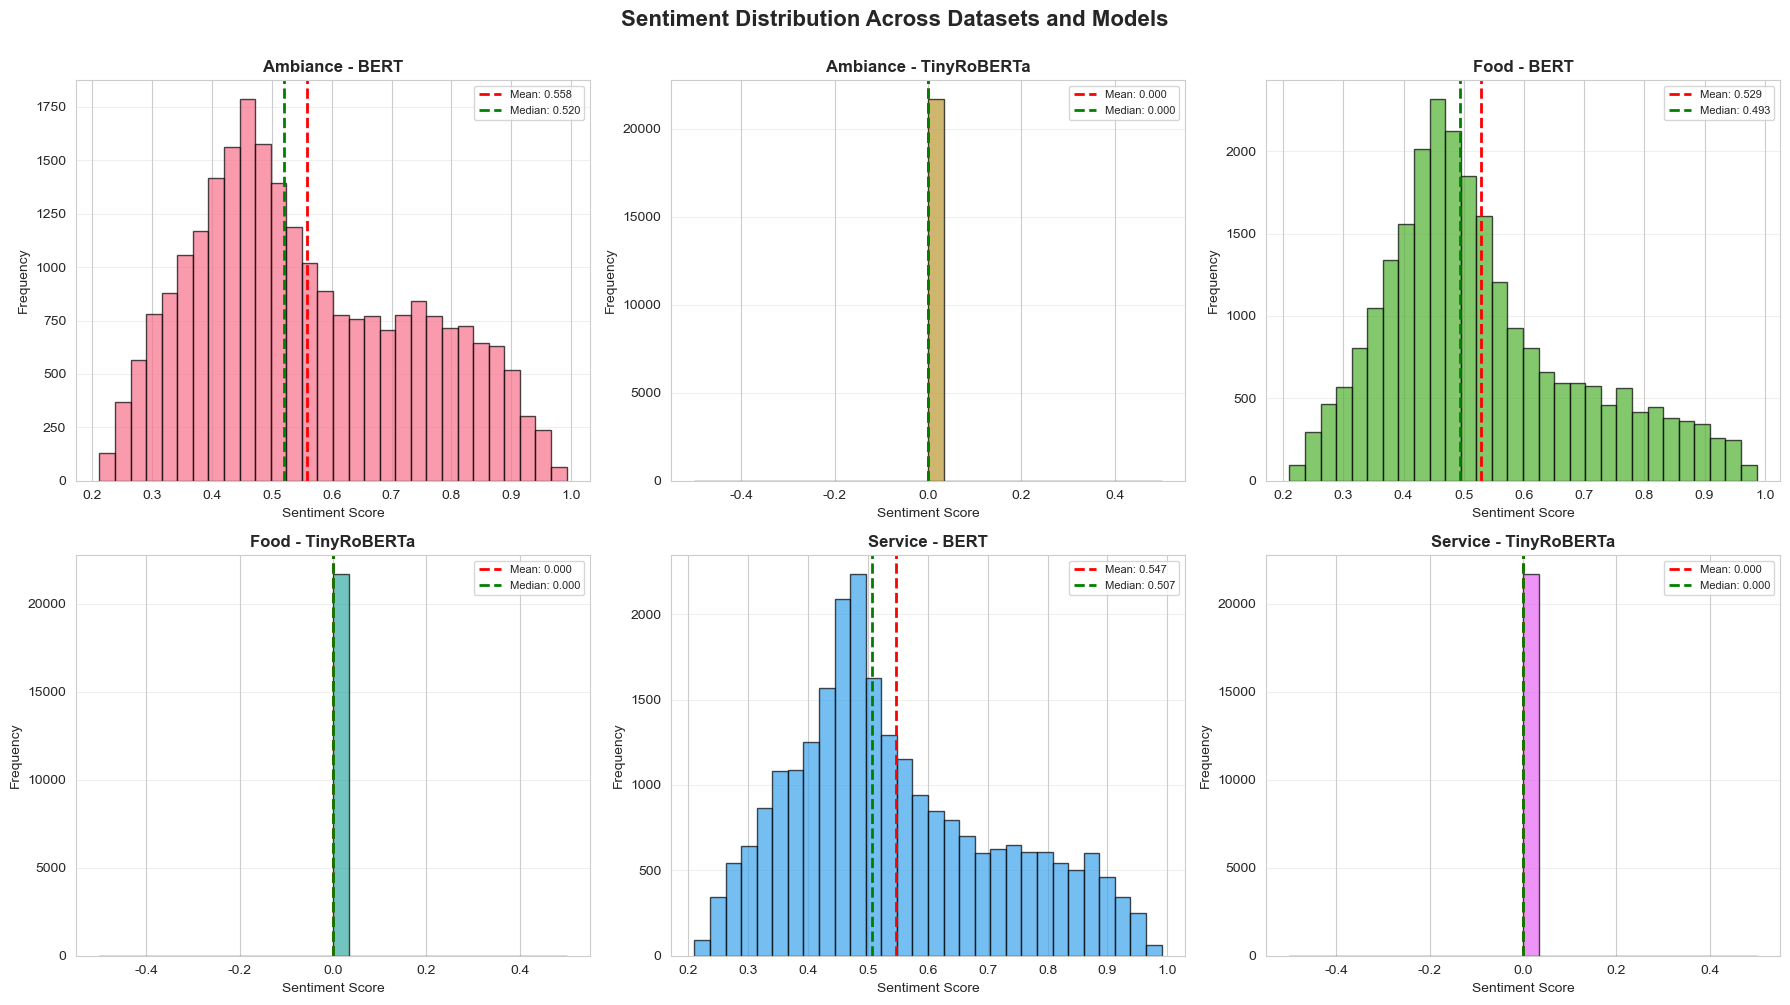

In [6]:
# 情感分布分析
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

datasets = ['Ambiance', 'Food', 'Service']
models = ['BERT', 'TinyRoBERTa']

plot_idx = 0
for dataset in datasets:
    for model in models:
        df_subset = all_data[(all_data['dataset'] == dataset) & (all_data['model'] == model)]
        
        ax = axes[plot_idx]
        
        # 绘制情感分布直方图
        ax.hist(df_subset['sentiment'], bins=30, edgecolor='black', alpha=0.7, color=sns.color_palette()[plot_idx])
        ax.set_title(f'{dataset} - {model}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Sentiment Score', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        
        # 添加统计信息
        mean_val = df_subset['sentiment'].mean()
        median_val = df_subset['sentiment'].median()
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.3f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.3f}')
        ax.legend(fontsize=8)
        
        plot_idx += 1

plt.suptitle('Sentiment Distribution Across Datasets and Models', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 6. 情感统计对比

=== Sentiment Statistics ===
                        Mean  Median     Std     Min     Max      Q1      Q3
dataset  model                                                              
Ambiance BERT         0.5582  0.5204  0.1824  0.2121  0.9925  0.4182  0.7051
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
Food     BERT         0.5289  0.4935  0.1621  0.2104  0.9865  0.4184  0.6154
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000
Service  BERT         0.5474  0.5074  0.1742  0.2104  0.9904  0.4247  0.6639
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000


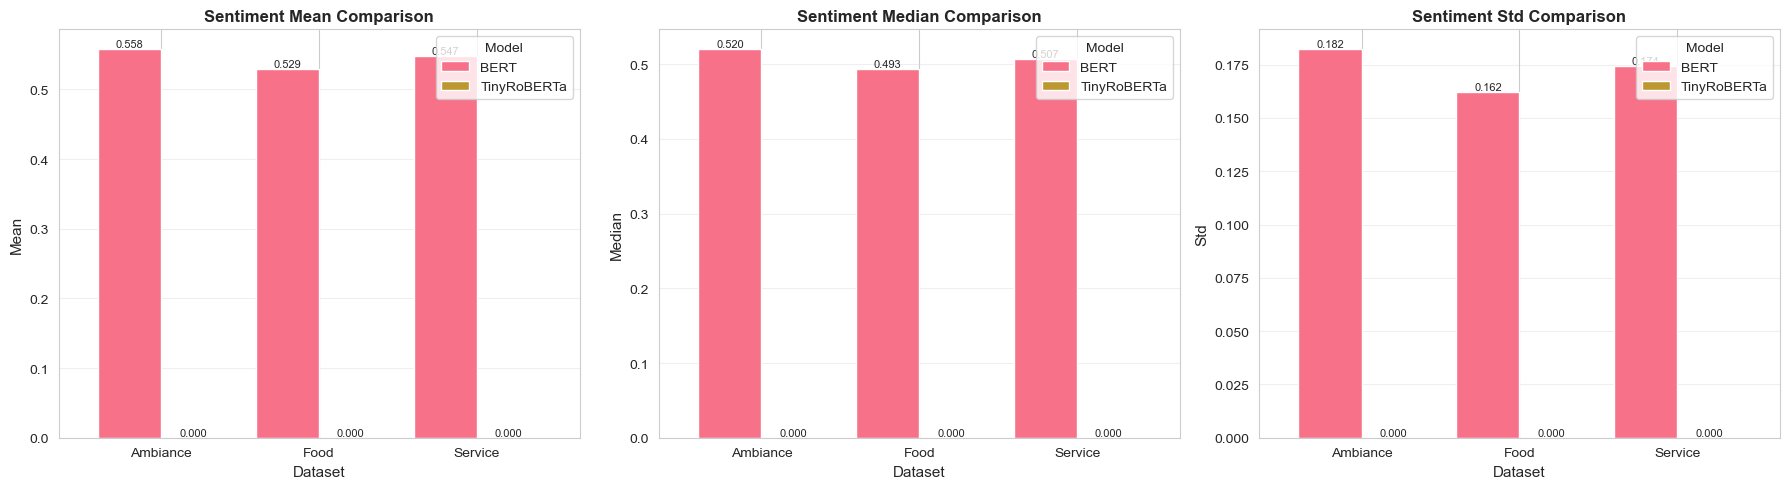

In [7]:
# 计算统计指标
sentiment_stats = all_data.groupby(['dataset', 'model'])['sentiment'].agg([
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Q1', lambda x: x.quantile(0.25)),
    ('Q3', lambda x: x.quantile(0.75))
]).round(4)

print("=== Sentiment Statistics ===")
print(sentiment_stats)

# 可视化对比
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Mean', 'Median', 'Std']
for idx, metric in enumerate(metrics):
    sentiment_stats[metric].unstack().plot(kind='bar', ax=axes[idx], width=0.8)
    axes[idx].set_title(f'Sentiment {metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Dataset', fontsize=11)
    axes[idx].set_ylabel(metric, fontsize=11)
    axes[idx].legend(title='Model', loc='best')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=0)
    
    # 添加数值标签
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%.3f', fontsize=8)

plt.tight_layout()
plt.show()

## 7. 箱线图对比 - 识别异常值

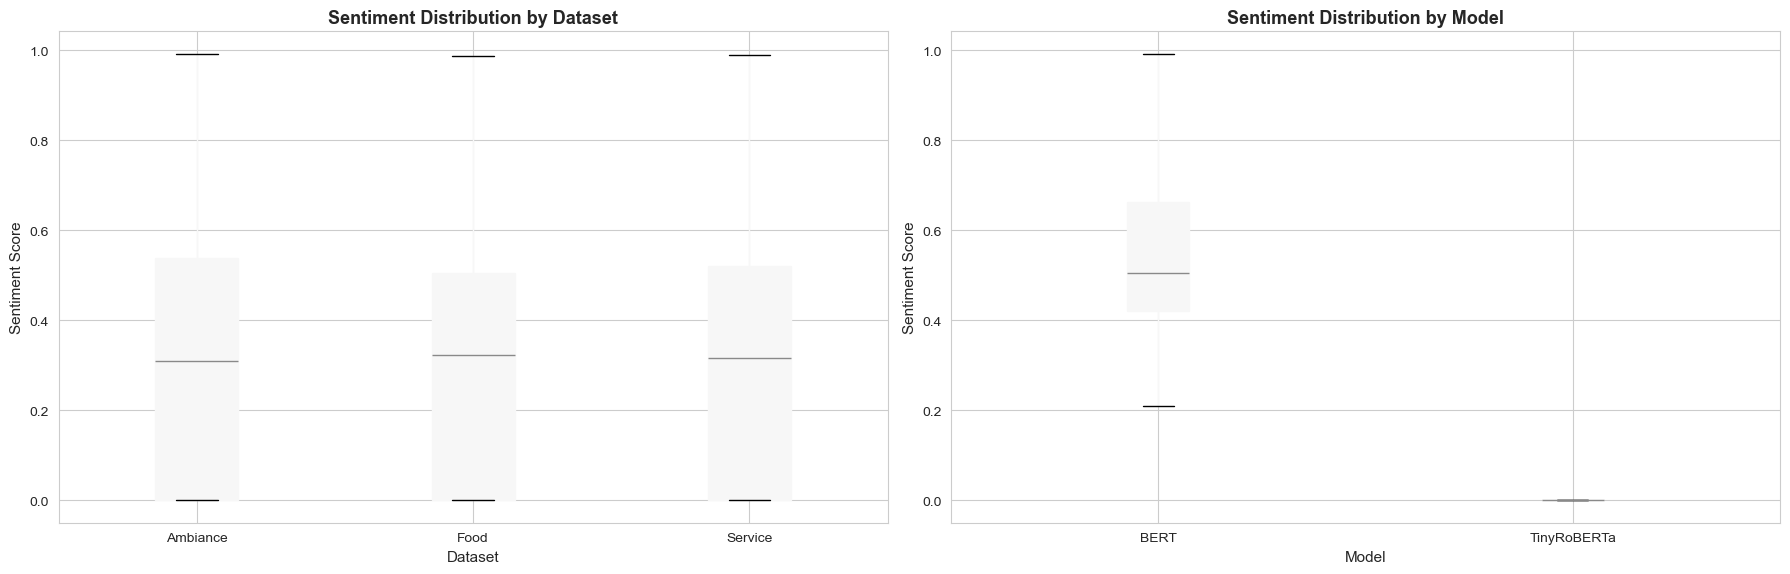

<Figure size 1400x600 with 0 Axes>

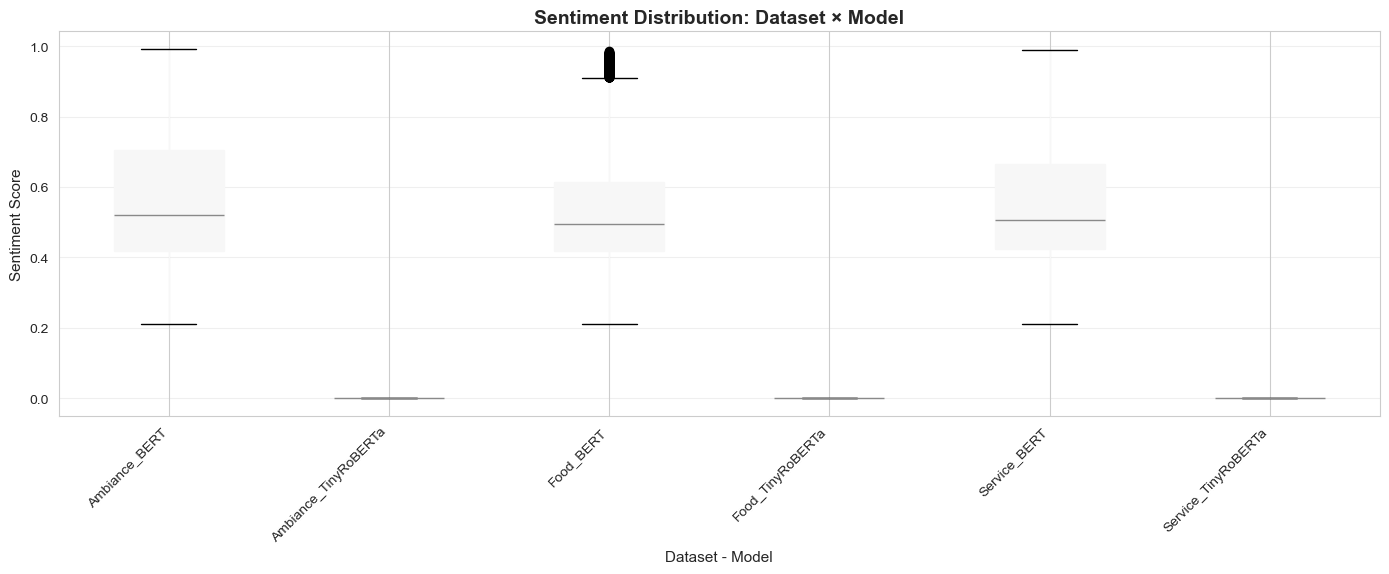

In [8]:
# 箱线图对比
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 按数据集分组
all_data.boxplot(column='sentiment', by='dataset', ax=axes[0], patch_artist=True)
axes[0].set_title('Sentiment Distribution by Dataset', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Dataset', fontsize=11)
axes[0].set_ylabel('Sentiment Score', fontsize=11)
axes[0].get_figure().suptitle('')

# 按模型分组
all_data.boxplot(column='sentiment', by='model', ax=axes[1], patch_artist=True)
axes[1].set_title('Sentiment Distribution by Model', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Sentiment Score', fontsize=11)
axes[1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

# 详细箱线图 - 数据集和模型的组合
plt.figure(figsize=(14, 6))
all_data['dataset_model'] = all_data['dataset'] + '_' + all_data['model']
all_data.boxplot(column='sentiment', by='dataset_model', figsize=(14, 6), patch_artist=True)
plt.title('Sentiment Distribution: Dataset × Model', fontsize=14, fontweight='bold')
plt.xlabel('Dataset - Model', fontsize=11)
plt.ylabel('Sentiment Score', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.suptitle('')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 8. 置信度分析

=== Confidence Statistics ===
                        Mean  Median     Std  Min     Max
dataset  model                                           
Ambiance BERT         0.1384  0.0386  0.2020  0.0  0.9937
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0  0.0000
Food     BERT         0.2582  0.2053  0.2180  0.0  0.9789
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0  0.0000
Service  BERT         0.1260  0.0673  0.1487  0.0  0.9479
         TinyRoBERTa  0.0000  0.0000  0.0000  0.0  0.0000


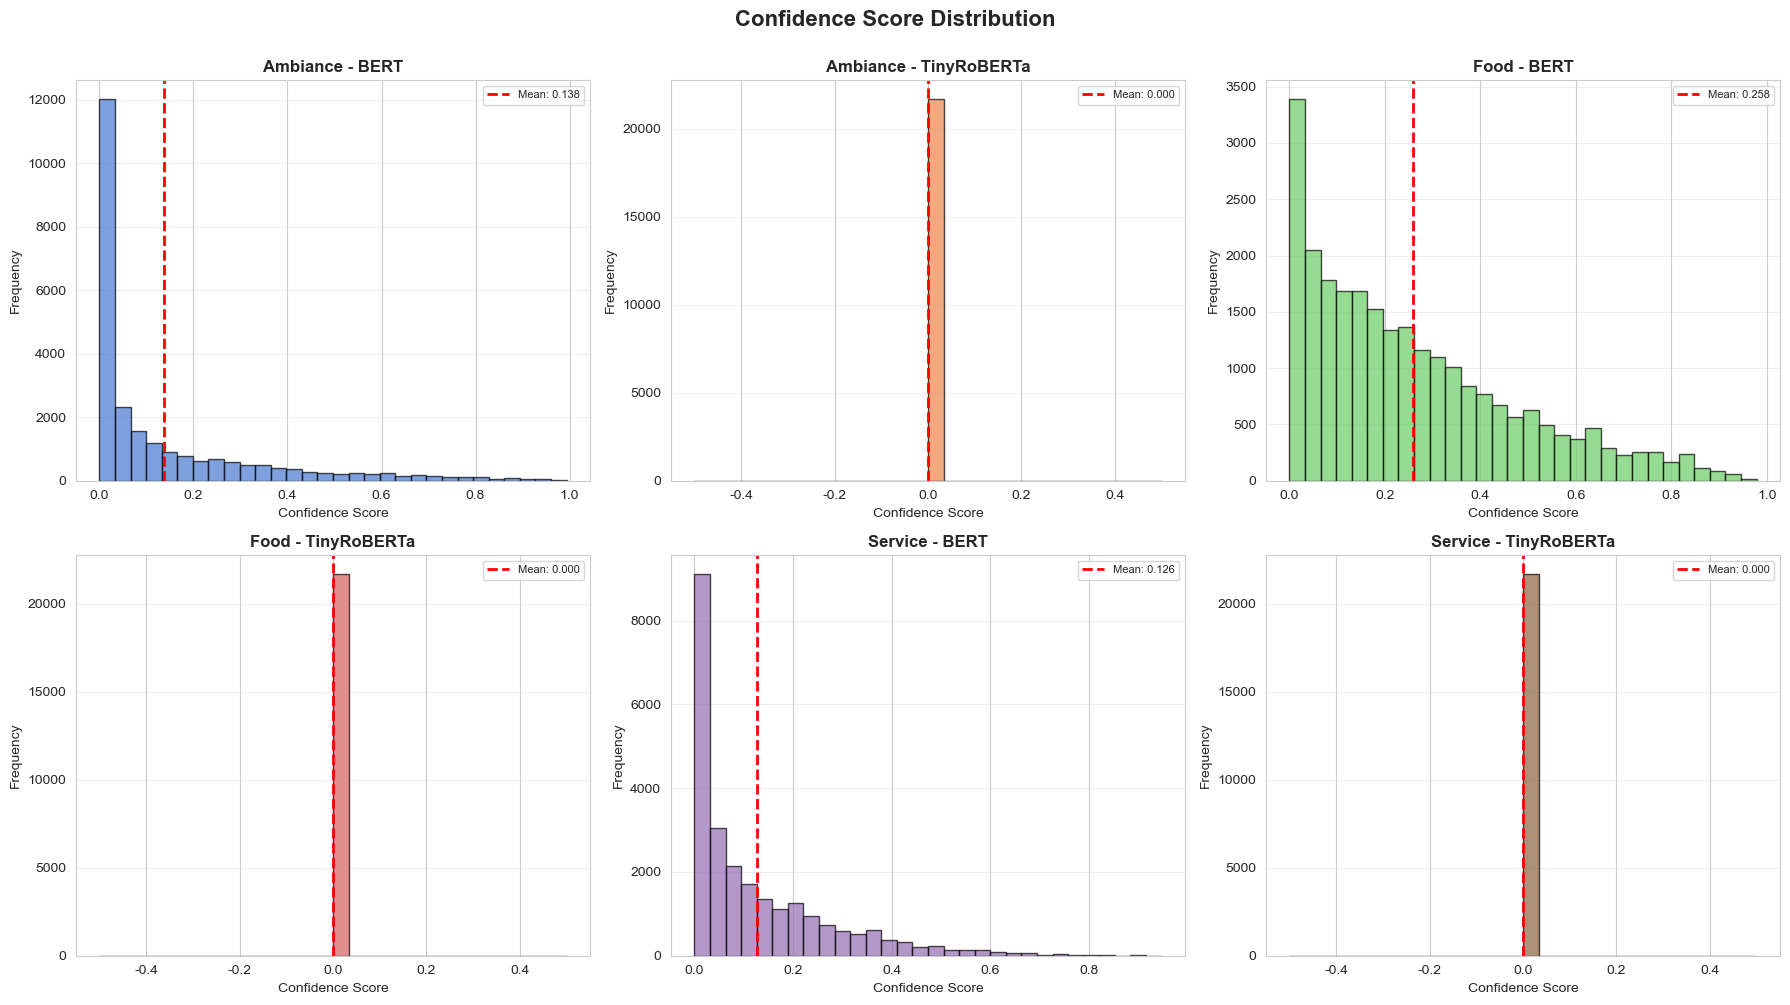

In [9]:
# 置信度统计
confidence_stats = all_data.groupby(['dataset', 'model'])['confidence'].agg([
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std', 'std'),
    ('Min', 'min'),
    ('Max', 'max')
]).round(4)

print("=== Confidence Statistics ===")
print(confidence_stats)

# 可视化置信度分布
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

plot_idx = 0
for dataset in datasets:
    for model in models:
        df_subset = all_data[(all_data['dataset'] == dataset) & (all_data['model'] == model)]
        
        ax = axes[plot_idx]
        ax.hist(df_subset['confidence'], bins=30, edgecolor='black', alpha=0.7, color=sns.color_palette('muted')[plot_idx])
        ax.set_title(f'{dataset} - {model}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Confidence Score', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        
        mean_conf = df_subset['confidence'].mean()
        ax.axvline(mean_conf, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_conf:.3f}')
        ax.legend(fontsize=8)
        
        plot_idx += 1

plt.suptitle('Confidence Score Distribution', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 9. 置信度对比图

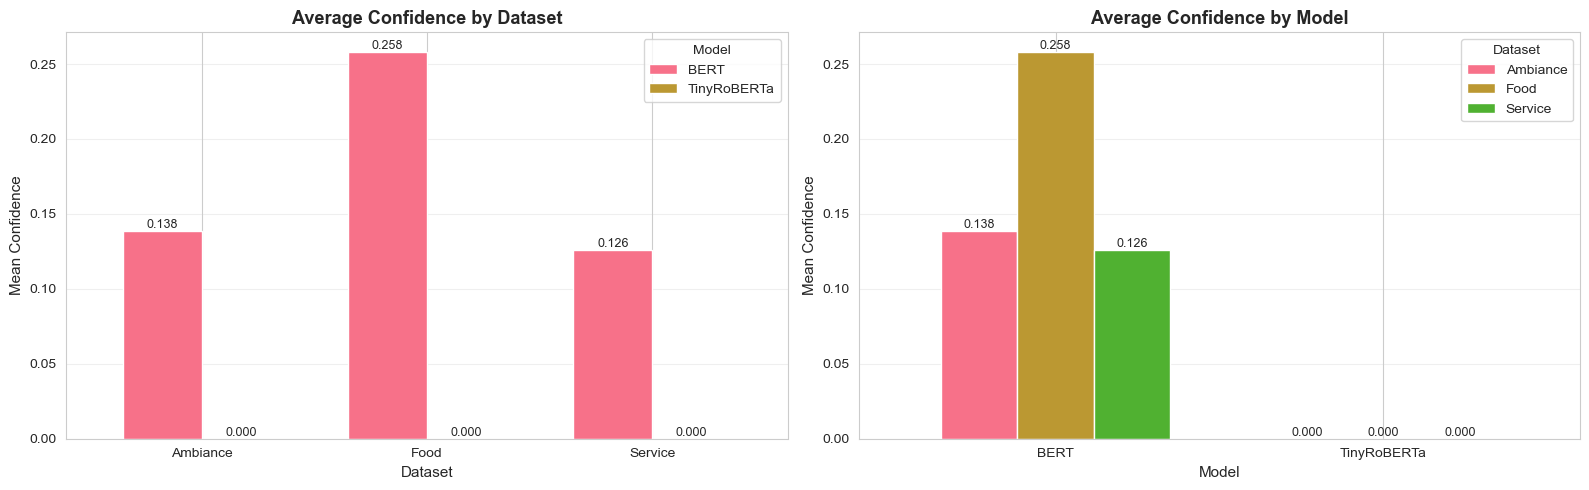

In [10]:
# 置信度均值对比
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 按数据集对比
confidence_by_dataset = all_data.groupby(['dataset', 'model'])['confidence'].mean().unstack()
confidence_by_dataset.plot(kind='bar', ax=axes[0], width=0.7)
axes[0].set_title('Average Confidence by Dataset', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Dataset', fontsize=11)
axes[0].set_ylabel('Mean Confidence', fontsize=11)
axes[0].legend(title='Model')
axes[0].grid(axis='y', alpha=0.3)
axes[0].tick_params(axis='x', rotation=0)

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', fontsize=9)

# 按模型对比
confidence_by_model = all_data.groupby(['model', 'dataset'])['confidence'].mean().unstack()
confidence_by_model.plot(kind='bar', ax=axes[1], width=0.7)
axes[1].set_title('Average Confidence by Model', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Mean Confidence', fontsize=11)
axes[1].legend(title='Dataset')
axes[1].grid(axis='y', alpha=0.3)
axes[1].tick_params(axis='x', rotation=0)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.3f', fontsize=9)

plt.tight_layout()
plt.show()

## 10. 情感 vs 置信度散点图

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  5 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


LinAlgError: SVD did not converge in Linear Least Squares

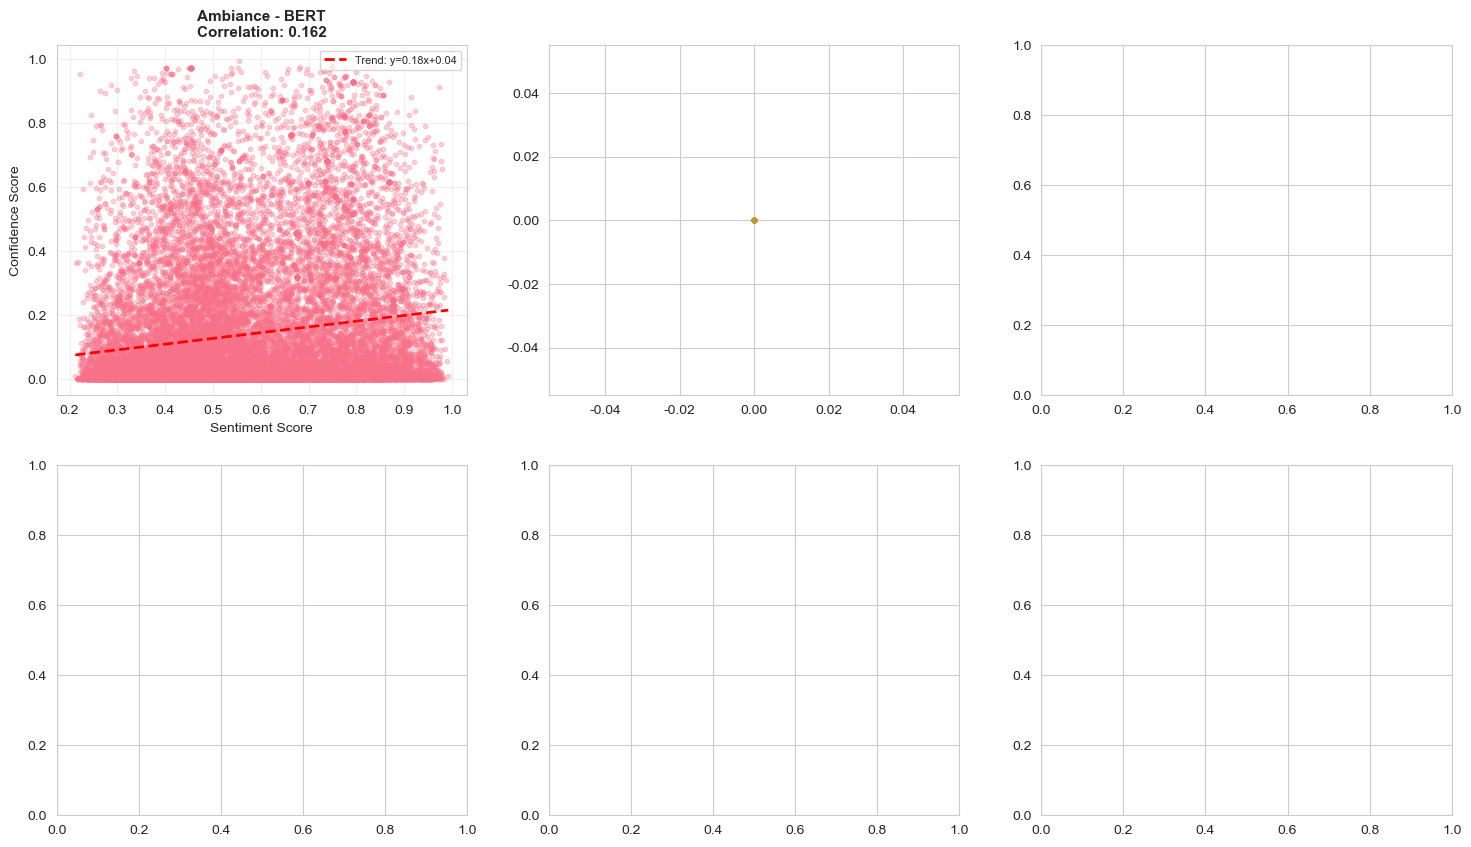

In [11]:
# 情感与置信度的关系
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

plot_idx = 0
for dataset in datasets:
    for model in models:
        df_subset = all_data[(all_data['dataset'] == dataset) & (all_data['model'] == model)]
        
        ax = axes[plot_idx]
        
        # 散点图 + 密度
        scatter = ax.scatter(df_subset['sentiment'], df_subset['confidence'], 
                           alpha=0.3, s=10, c=sns.color_palette()[plot_idx])
        
        # 添加趋势线
        z = np.polyfit(df_subset['sentiment'], df_subset['confidence'], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df_subset['sentiment'].min(), df_subset['sentiment'].max(), 100)
        ax.plot(x_line, p(x_line), 'r--', linewidth=2, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')
        
        # 计算相关系数
        corr = df_subset[['sentiment', 'confidence']].corr().iloc[0, 1]
        
        ax.set_title(f'{dataset} - {model}\nCorrelation: {corr:.3f}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Sentiment Score', fontsize=10)
        ax.set_ylabel('Confidence Score', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)
        
        plot_idx += 1

plt.suptitle('Sentiment vs Confidence: Correlation Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 11. 文本长度分析

In [ ]:
# 文本长度统计
text_stats = all_data.groupby(['dataset', 'model']).agg({
    'text_length': ['mean', 'median', 'std'],
    'word_count': ['mean', 'median', 'std']
}).round(2)

print("=== Text Length Statistics ===")
print(text_stats)

# 可视化
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 字符数对比
text_length_mean = all_data.groupby(['dataset', 'model'])['text_length'].mean().unstack()
text_length_mean.plot(kind='bar', ax=axes[0, 0], width=0.7)
axes[0, 0].set_title('Average Text Length (Characters)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Dataset', fontsize=11)
axes[0, 0].set_ylabel('Characters', fontsize=11)
axes[0, 0].legend(title='Model')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=0)

for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt='%.1f', fontsize=8)

# 词数对比
word_count_mean = all_data.groupby(['dataset', 'model'])['word_count'].mean().unstack()
word_count_mean.plot(kind='bar', ax=axes[0, 1], width=0.7)
axes[0, 1].set_title('Average Word Count', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Dataset', fontsize=11)
axes[0, 1].set_ylabel('Words', fontsize=11)
axes[0, 1].legend(title='Model')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=0)

for container in axes[0, 1].containers:
    axes[0, 1].bar_label(container, fmt='%.1f', fontsize=8)

# 文本长度分布箱线图
all_data.boxplot(column='word_count', by='dataset', ax=axes[1, 0])
axes[1, 0].set_title('Word Count Distribution by Dataset', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Dataset', fontsize=11)
axes[1, 0].set_ylabel('Word Count', fontsize=11)
axes[1, 0].get_figure().suptitle('')

# 按模型的箱线图
all_data.boxplot(column='word_count', by='model', ax=axes[1, 1])
axes[1, 1].set_title('Word Count Distribution by Model', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Model', fontsize=11)
axes[1, 1].set_ylabel('Word Count', fontsize=11)
axes[1, 1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

## 12. 文本长度 vs 情感/置信度

In [ ]:
# 文本长度与情感/置信度的关系
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 文本长度 vs 情感
for dataset in datasets:
    df_subset = all_data[all_data['dataset'] == dataset]
    axes[0].scatter(df_subset['word_count'], df_subset['sentiment'], alpha=0.3, s=5, label=dataset)

axes[0].set_title('Word Count vs Sentiment', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Word Count', fontsize=11)
axes[0].set_ylabel('Sentiment Score', fontsize=11)
axes[0].legend()
axes[0].grid(alpha=0.3)

# 文本长度 vs 置信度
for dataset in datasets:
    df_subset = all_data[all_data['dataset'] == dataset]
    axes[1].scatter(df_subset['word_count'], df_subset['confidence'], alpha=0.3, s=5, label=dataset)

axes[1].set_title('Word Count vs Confidence', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Word Count', fontsize=11)
axes[1].set_ylabel('Confidence Score', fontsize=11)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 计算相关系数
print("=== Correlation Analysis ===")
for dataset in datasets:
    df_subset = all_data[all_data['dataset'] == dataset]
    corr_sentiment = df_subset[['word_count', 'sentiment']].corr().iloc[0, 1]
    corr_confidence = df_subset[['word_count', 'confidence']].corr().iloc[0, 1]
    print(f"\n{dataset}:")
    print(f"  Word Count vs Sentiment: {corr_sentiment:.4f}")
    print(f"  Word Count vs Confidence: {corr_confidence:.4f}")

## 13. 模型对比 - 直接比较

In [ ]:
# 两个模型在相同数据集上的对比
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, dataset in enumerate(datasets):
    bert_data = all_data[(all_data['dataset'] == dataset) & (all_data['model'] == 'BERT')]
    roberta_data = all_data[(all_data['dataset'] == dataset) & (all_data['model'] == 'TinyRoBERTa')]
    
    ax = axes[idx]
    
    # 情感分布对比
    ax.hist(bert_data['sentiment'], bins=30, alpha=0.5, label='BERT', color='blue', edgecolor='black')
    ax.hist(roberta_data['sentiment'], bins=30, alpha=0.5, label='TinyRoBERTa', color='orange', edgecolor='black')
    
    ax.set_title(f'{dataset} Dataset', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sentiment Score', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Model Comparison: Sentiment Distribution Overlay', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 14. 热力图 - 综合视图

In [ ]:
# 创建汇总表
summary_metrics = all_data.groupby(['dataset', 'model']).agg({
    'sentiment': 'mean',
    'confidence': 'mean',
    'word_count': 'mean'
}).round(3)

# 热力图
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['sentiment', 'confidence', 'word_count']
titles = ['Average Sentiment Score', 'Average Confidence Score', 'Average Word Count']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    pivot_data = summary_metrics[metric].unstack()
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[idx], 
                cbar_kws={'label': metric}, linewidths=0.5)
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Model', fontsize=11)
    axes[idx].set_ylabel('Dataset', fontsize=11)

plt.tight_layout()
plt.show()

## 15. 城市分布分析（如果有城市数据）

In [ ]:
# 城市数据分析
if 'city' in all_data.columns and all_data['city'].notna().sum() > 0:
    print("=== Top 10 Cities by Review Count ===")
    top_cities = all_data['city'].value_counts().head(10)
    print(top_cities)
    
    # 可视化
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # 城市评论数
    top_cities.plot(kind='barh', ax=axes[0], color='skyblue', edgecolor='black')
    axes[0].set_title('Top 10 Cities by Review Count', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Number of Reviews', fontsize=11)
    axes[0].set_ylabel('City', fontsize=11)
    axes[0].grid(axis='x', alpha=0.3)
    
    # 城市情感均值
    city_sentiment = all_data.groupby('city')['sentiment'].mean().sort_values(ascending=False).head(10)
    city_sentiment.plot(kind='barh', ax=axes[1], color='lightcoral', edgecolor='black')
    axes[1].set_title('Top 10 Cities by Average Sentiment', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Average Sentiment Score', fontsize=11)
    axes[1].set_ylabel('City', fontsize=11)
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("❌ No city data available")

## 16. 综合结论总结

In [ ]:
print("="*80)
print("                         📊 COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)

print("\n1️⃣ DATA OVERVIEW")
print("-" * 80)
print(f"   Total Reviews Analyzed: {len(all_data):,}")
print(f"   Datasets: {', '.join(datasets)}")
print(f"   Models: {', '.join(models)}")

print("\n2️⃣ SENTIMENT ANALYSIS")
print("-" * 80)
sentiment_summary = all_data.groupby('dataset')['sentiment'].agg(['mean', 'std'])
for dataset in datasets:
    mean_val = sentiment_summary.loc[dataset, 'mean']
    std_val = sentiment_summary.loc[dataset, 'std']
    print(f"   {dataset:12s}: Mean = {mean_val:.4f}, Std = {std_val:.4f}")

print("\n3️⃣ MODEL PERFORMANCE")
print("-" * 80)
model_summary = all_data.groupby('model')['confidence'].agg(['mean', 'std'])
for model in models:
    mean_conf = model_summary.loc[model, 'mean']
    std_conf = model_summary.loc[model, 'std']
    print(f"   {model:15s}: Mean Confidence = {mean_conf:.4f}, Std = {std_conf:.4f}")

print("\n4️⃣ TEXT CHARACTERISTICS")
print("-" * 80)
text_summary = all_data.groupby('dataset')['word_count'].agg(['mean', 'median'])
for dataset in datasets:
    mean_words = text_summary.loc[dataset, 'mean']
    median_words = text_summary.loc[dataset, 'median']
    print(f"   {dataset:12s}: Mean = {mean_words:.1f} words, Median = {median_words:.1f} words")

print("\n5️⃣ KEY INSIGHTS")
print("-" * 80)

# 找出情感最高和最低的数据集
best_sentiment_dataset = all_data.groupby('dataset')['sentiment'].mean().idxmax()
worst_sentiment_dataset = all_data.groupby('dataset')['sentiment'].mean().idxmin()
print(f"   ✅ Highest Average Sentiment: {best_sentiment_dataset}")
print(f"   ⚠️  Lowest Average Sentiment: {worst_sentiment_dataset}")

# 找出置信度最高的模型
best_confidence_model = all_data.groupby('model')['confidence'].mean().idxmax()
print(f"   🎯 Highest Confidence Model: {best_confidence_model}")

# 数据规模对比
largest_dataset = all_data['dataset'].value_counts().idxmax()
largest_count = all_data['dataset'].value_counts().max()
print(f"   📈 Largest Dataset: {largest_dataset} ({largest_count:,} reviews)")

print("\n6️⃣ CORRELATIONS")
print("-" * 80)
overall_corr = all_data[['sentiment', 'confidence', 'word_count']].corr()
print(f"   Sentiment vs Confidence: {overall_corr.loc['sentiment', 'confidence']:.4f}")
print(f"   Sentiment vs Word Count: {overall_corr.loc['sentiment', 'word_count']:.4f}")
print(f"   Confidence vs Word Count: {overall_corr.loc['confidence', 'word_count']:.4f}")

print("\n" + "="*80)
print("                              ✨ ANALYSIS COMPLETE ✨")
print("="*80)

## 17. 导出分析结果

In [ ]:
# 创建综合报告CSV
output_dir = Path('../results')

# 汇总统计
summary_report = all_data.groupby(['dataset', 'model']).agg({
    'sentiment': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'confidence': ['mean', 'median', 'std'],
    'word_count': ['mean', 'median', 'std']
}).round(4)

summary_report.to_csv(output_dir / 'comprehensive_analysis_summary.csv')
print("✅ Summary report saved to: comprehensive_analysis_summary.csv")

# 保存合并后的数据
all_data.to_csv(output_dir / 'all_data_combined.csv', index=False)
print("✅ Combined dataset saved to: all_data_combined.csv")

print("\n📁 All analysis files saved successfully!")